In [37]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
from torch import einsum
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.cifar import CIFAR10
import scipy
from torchmetrics.image.fid import FrechetInceptionDistance
import cv2
import skimage
import math
from inspect import isfunction
from functools import partial
from einops.layers.torch import Rearrange
from einops import rearrange, reduce
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
'''
Define parameters for model
'''
timesteps = 10000
timesteps_for_generating = 400
steps_for_FID = 10
epochs = 1500
batch_size = 128
channels = 3
image_size = 32
GROUPS = 1
n_real = 10  ## how many real images we want to sent in the Inception Model to get the FID score. i.e. 128 * n_real images will be sent. 
n_samples = 256  ## how many images we eant to generate
n_feature = 192  ## the parameter of FID calcultion. Needs to be in the range[64, 192, 768, 2048]. The bigger it is, the better the preformance is. 
dataset_path = "./datasets"
model_path = "./ddpm_cifar.pt"
fig_path = "./FID.png"
loss_path = "./loss.png"
epoch_loss_path = "./epoch_loss.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if_train = True

In [ ]:
'''
Rescale the images
'''
def scale_image(images, new_shape):
    new_images = []
    for image in images:
        new_image = skimage.transform.resize(image, new_shape, 0)
        new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        new_images.append(new_image)
    return np.asarray(new_images, dtype=np.uint8)


'''
FID calculation
'''
def get_fid(images1: torch.Tensor, images2: torch.Tensor, n_feature=64) -> torch.Tensor:
    new_size = (3, 299, 299)
    fid = FrechetInceptionDistance(feature=n_feature)
    real = images1.clone()
    fake = images2.clone()
    
    # convert into numpy to resize
    if type(real) is torch.Tensor:
        real = real.detach().cpu().numpy()
        
    if type(fake) is torch.Tensor:
        fake = fake.detach().cpu().numpy()
        
    # resize to (3, 299, 299)
    images1 = scale_image(real, new_size)
    images2 = scale_image(fake, new_size)
    
    # convert it back to tensor
    images1 = torch.tensor(images1)
    images2 = torch.tensor(images2)
    
    # update the fid with new tensor
    print("\nUpdating the fid calculator....\n")
    fid.update(images1, real=True)
    fid.update(images2, real=False)
    
    # get the fid score
    score = fid.compute()
    print("\nThe current FID score = {}. \n".format(score))
    fid.reset()
    
    return score

In [ ]:
'''
Utilty functions
'''
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [ ]:
'''
Prepare all component blocks
'''
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1, groups=GROUPS),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1, groups=GROUPS),
    )
    
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    
    
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [ ]:
'''
Define U-Net
'''
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [ ]:
'''
Define beta scheduing methods
'''
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [ ]:
'''
Prepare a serie of values for sampling 
'''
# define beta schedule, use linear scheduling as they did in the paper. 
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
'''
Define a serie of tranforms
'''
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [ ]:
'''
Define forward diffusion, corresponding to Algorithm 1 in the paper.
'''
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
'''
Define loss functon for following training.
'''
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
'''
Prepare dataset
'''
# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])
cifar_dataset = CIFAR10(root=dataset_path,
                        train=True,
                        download=True,
                        transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

# create dataloader
dataloader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
'''
Define original generating function. 
'''
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [ ]:
'''
Define modified generating function
'''
def generate_new_images(model, timesteps, images_size, batch_size=256, channels=1):
    imgs = []
    shape = (batch_size, channels, images_size, images_size)
    device = next(model.parameters()).device
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model=model, 
                       x=img, 
                       t=torch.full((shape[0],), 
                                    i, 
                                    device=device, dtype=torch.long), 
                       t_index=i)
        imgs.append(img.cpu())
    return imgs

In [ ]:
'''
Define parameters for calculating the FID score
'''
n_steps = 2000
n_reverse = 5
num_images = 25
reverse_path = './reverse_CIFAR.png'
results_path = './results_CIFAR.png'
real_path = './real_CIFAR.png'
reverse_fid_path = './reverse_FID_CIFAR.png'

In [39]:
'''
Laod the trained data
'''
model_path = './Results/Cao/CIFAR/Results_epoch_600_GPU/ddpm_cifar.pt'
model = Unet(dim=image_size,
             channels=channels, 
             dim_mults=(1, 2, 4,))
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model is loaded from {}".format(model_path))

Model is loaded from ./Results/Cao/CIFAR/Results_epoch_600_GPU/ddpm_cifar.pt


In [40]:
'''
Prepare the real images. 
'''
batches = []
cnt = 0
for batch in dataloader:
    if (cnt == n_real):
        break
    batches.append(batch[0])
    cnt += 1
    
real = batches[0]

for i in range(1, len(batches)):
    real = torch.cat((real, batches[i]))

print("The real images have type as {}, \nand the shape is {}. ".format(type(real), real.shape))


The real images have type as <class 'torch.Tensor'>, 
and the shape is torch.Size([1280, 3, 32, 32]). 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


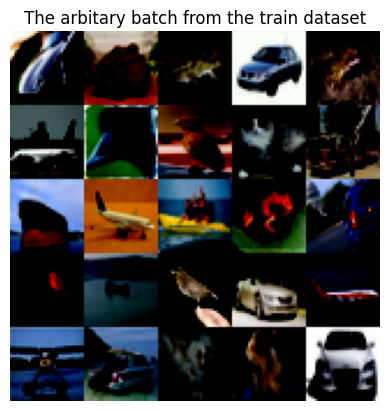

In [41]:
'''
Visualize the real images
'''
test = real[:num_images]
test = einops.rearrange(test, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(num_images ** 0.5))
test = test.detach().numpy()
print(test.shape)

plt.imshow(test)
title = f"The arbitary batch from the train dataset"
plt.title(title)
plt.axis('off')
plt.savefig(real_path)

In [42]:
'''
Generate the fake images. 
'''
print(n_samples)
fakes = generate_new_images(model=model,
                            timesteps=n_steps,
                            images_size=32,
                            batch_size=256,
                            channels=3)

In [43]:
'''Only needed when use external GPU to generate the fake images'''
# '''
# Load the fakes.pt
# '''
# fakes = torch.load('./fakes.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


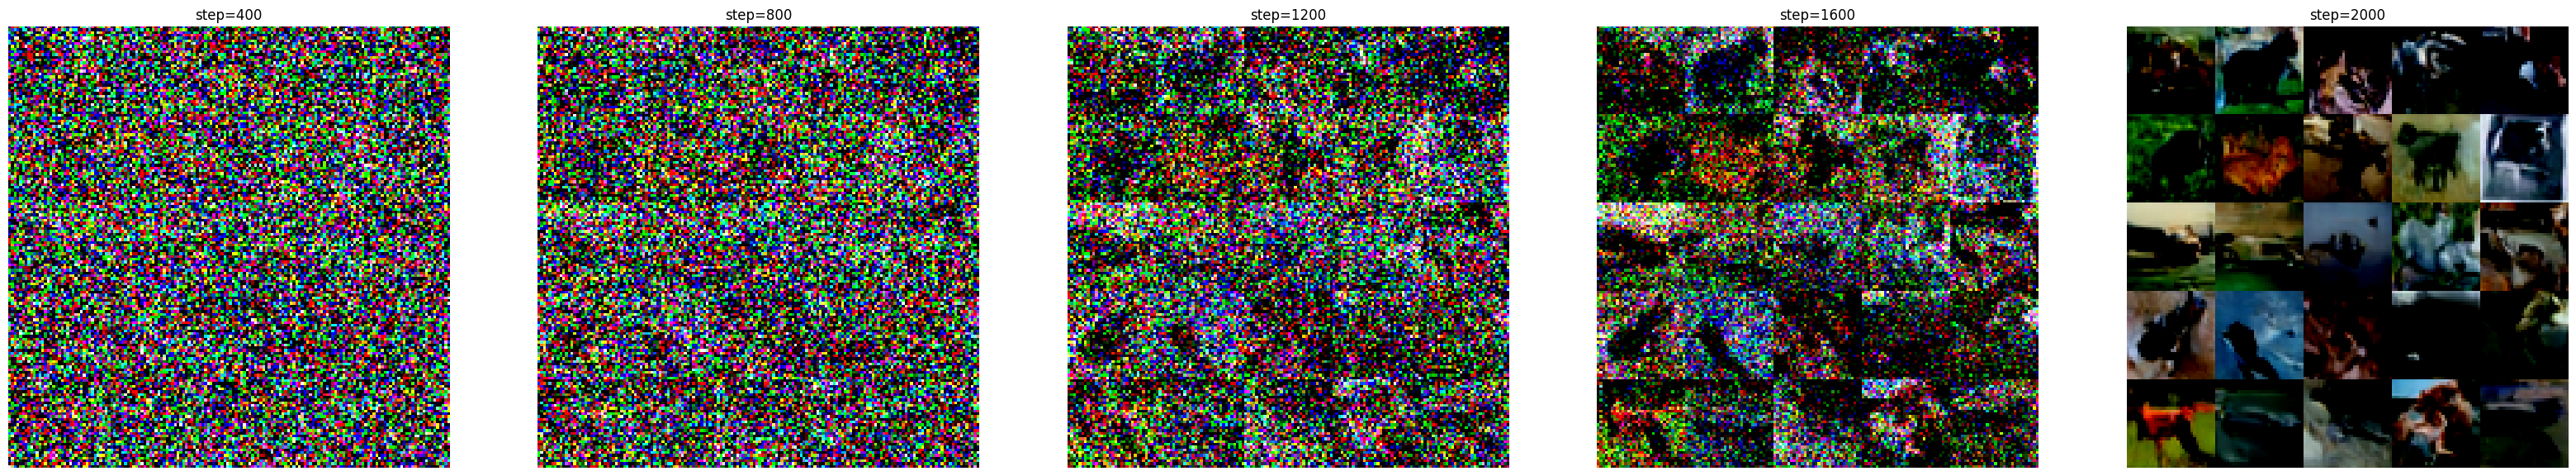

In [44]:
'''
Visualize the reverse process. 
'''
image_step = n_steps // n_reverse
cols = len(fakes) // image_step
fig = plt.figure(figsize=(8*cols, 12))
# plt.title('Reverse process')
# plt.axis('off')
cnt = 1
for i in range(len(fakes)):
    if (i+1) % image_step == 0:
        fig.add_subplot(1, cols, cnt)
        fake_step = einops.rearrange(fakes[i][:num_images], "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(num_images ** 0.5))
        plt.imshow(fake_step, cmap='gray')
        plt.axis('off')
        title = f"step={i+1}"
        plt.title(title)
        cnt += 1
plt.savefig(reverse_path)

In [45]:
'''
Calculate the FID score
'''
print("\nCalculating the FID score......\n")
score = get_fid(images1=real,
                images2=fakes[len(fakes)-1],
                n_feature=192)


Calculating the FID score......


Updating the fid calculator....


The current FID score = 3.3993730545043945. 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


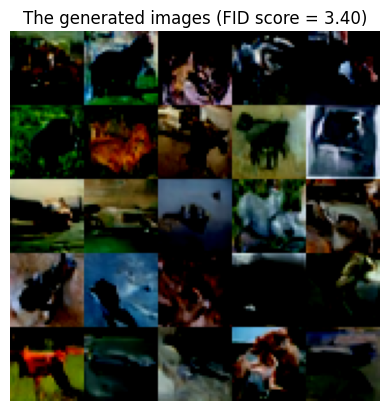

In [46]:
'''
Visualize the result.
'''
fake_last_step = einops.rearrange(fakes[len(fakes)-1][:num_images], "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(num_images ** 0.5))
fake_last_step = fake_last_step.detach().numpy()
plt.title('The generated images (FID score = {:.2f})'.format(score))
plt.imshow(fake_last_step)
plt.axis('off')
plt.savefig(results_path)

In [47]:
'''
Visualize FID of every step
'''
FID_record = []
for i in range (len(fakes)):
  if ((i+1) % (n_steps / 10) == 0):
    FID_record.append([(i+1), get_fid(images1=real, 
                                      images2=fakes[i],
                                      n_feature=192)])

FID_record = np.asarray(FID_record, dtype='float32')


Updating the fid calculator....


The current FID score = 194.24900817871094. 


Updating the fid calculator....


The current FID score = 194.76467895507812. 


Updating the fid calculator....


The current FID score = 193.4341583251953. 


Updating the fid calculator....


The current FID score = 191.9327850341797. 


Updating the fid calculator....


The current FID score = 186.5292510986328. 


Updating the fid calculator....


The current FID score = 181.1986846923828. 


Updating the fid calculator....


The current FID score = 166.15476989746094. 


Updating the fid calculator....


The current FID score = 142.511474609375. 


Updating the fid calculator....


The current FID score = 97.85316467285156. 


Updating the fid calculator....


The current FID score = 3.3993730545043945. 



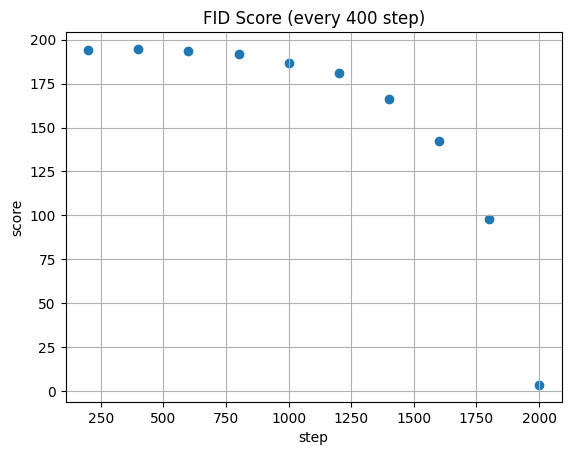

In [48]:
fig_fid_steps = plt.figure()
plt.scatter(FID_record[:, 0], FID_record[:, 1])
plt.title("FID Score (every {} step)".format(image_step))
plt.xlabel("step")
plt.ylabel("score")
plt.grid(visible=True)
plt.savefig(reverse_fid_path)